In [1]:
from nlp import Dataset
import pandas as pd
import re
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
from torch.nn import Softmax
from torch import tensor, where
from torch.utils.data import DataLoader

from random import seed

seed(42)


NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
# read our tweet sample
tweets = pd.read_csv('../data/cleaned_tweets.csv', encoding='ISO-8859-1')

# convert the date to a datetime format
tweets['date'] = pd.to_datetime(tweets['TweetAt']).astype('datetime64[ms]')

# set our index as our datetime column and delete the date columns
tweets.index = tweets['date']
del tweets['date']

# Sort our tweets
tweets.sort_index(inplace=True)

In [3]:
# create an index that we can reference later
tweets['index'] = range(tweets.shape[0])

In [4]:
tweets

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,month,text,label,index
date,,,,,,,,,,
2020-01-04,29309,74261,"Tidal County, Knoxville, TN",01-04-2020,Overwhelmed with info Before you act stop Ask ...,Positive,1,Overwhelmed with info Before you act stop Ask ...,2,0
2020-01-04,29316,74268,"Fort George G. Meade, Md.",01-04-2020,Malwarebytes rounded up some useful tips for s...,Extremely Positive,1,Malwarebytes rounded up some useful tips for s...,2,1
2020-01-04,29317,74269,Australia,01-04-2020,A Queensland mum has posted a heartbreaking pi...,Extremely Negative,1,A Queensland mum has posted a heartbreaking pi...,0,2
2020-01-04,29318,74270,Debt Jubilee,01-04-2020,New President Trump says U S gasoline prices w...,Neutral,1,New President Trump says U S gasoline prices w...,1,3
2020-01-04,29319,74271,??to Miami,01-04-2020,SUPERMARKET SAFETY is the latest grocery chain...,Extremely Positive,1,SUPERMARKET SAFETY is the latest grocery chain...,2,4
...,...,...,...,...,...,...,...,...,...,...
2020-12-04,42559,87511,U.S.A,12-04-2020,@CNN Pork prices will go up soon they close it...,Neutral,12,Pork prices will go up soon they close it. I g...,1,6837
2020-12-04,42556,87508,"Nevada, USA",12-04-2020,Beware of scammers trying to sell fake vaccine...,Extremely Negative,12,Beware of scammers trying to sell fake vaccine...,0,6838
2020-12-04,42554,87506,"Nabunturan, Davao Region",12-04-2020,Yesterday during the Black Saturday?..\r\r\nat...,Neutral,12,Yesterday during the Black Saturday?..\r\r\nat...,1,6839


In [5]:
# load up a pre-trained bert

BERT_MODEL = 'distilbert-base-uncased'

bert_tokenizer = DistilBertTokenizerFast.from_pretrained(BERT_MODEL)


In [6]:
# Grab the same training data as the model_drift notebook
tweets = tweets[:'2020-03']

In [7]:
# Create a Dataset
tweet_dataset = Dataset.from_pandas(tweets.reset_index()[['text', 'label', 'index']])

# Dataset has a built in train test split method
tweet_dataset = tweet_dataset.train_test_split(test_size=0.2)

train_set = tweet_dataset['train']
test_set = tweet_dataset['test']

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# We will pad our dataset so that our input matrices are the same length
def preprocess(data):
    return bert_tokenizer(data['text'], padding=True, truncation=True, max_length=128)

# map the preprocess function over the dataset
train_set = train_set.map(preprocess, batched=True, batch_size=len(train_set))
test_set = test_set.map(preprocess, batched=True, batch_size=len(test_set))

train_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label', 'index'])
test_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label', 'index'])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
# Define a sequence classification model
sequence_classification_model = DistilBertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=3)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

![title](../images/aum.png)


In [10]:
# https://github.com/asappresearch/aum
from aum import AUMCalculator

# Set a directory to save our results
save_dir = './clean'
# Setting compressed to False gives us information over several epochs
aum_calculator = AUMCalculator(save_dir, compressed=False)

In [11]:
# We are going to define the training process without the training arguments

In [12]:
from transformers import AdamW
from transformers import get_scheduler

# Define our optimizer. Nothing special here
optimizer = AdamW(sequence_classification_model.parameters(), lr=5e-5)
train_loader = DataLoader(train_set, batch_size=64, shuffle=False)

# Train for 10 epochs to get as much data as possible
num_epochs = 10
# Set the number of training steps
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

/opt/homebrew/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

# Set our model to training mode as opposed to .eval()
sequence_classification_model.train()

for epoch in range(num_epochs):
    # For every epoch, iterate over batches of data
    for batch in train_loader:
        # pass the data into the model without the index column
        _batch = {k: v for k, v in batch.items() if k not in ('index',)}
        _batch['labels'] = _batch['label']  # not very effecient way to change the label name for the siamese network
        del _batch['label']
        outputs = sequence_classification_model(**_batch)
        
        # PyTorch training code
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        
        # Update records in our AUM Calculator
        records = aum_calculator.update(outputs.logits, batch['label'], batch['index'].tolist())
        
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/270 [00:00<?, ?it/s]

In [14]:
# Create the final csvs for analysis
aum_calculator.finalize()

In [15]:
# Read the compressed values
# Lower values are meant to signify potentially mislabeled data
# Higher values are meant to signify potentially properly labelled data
aum_values = pd.read_csv('./clean/aum_values.csv')

# one value per datapoint
print(aum_values.shape)

# Most likely to be labelled correctly
aum_values.head()

(1725, 2)


,sample_id,aum
0,2137,4.447078
1,1509,4.397057
2,1424,4.384803
3,776,4.371539
4,1325,4.365264


In [16]:
# Most likely to be labelled incorrectly
aum_values.tail()

,sample_id,aum
1720,487,-2.087449
1721,1199,-2.205735
1722,521,-2.224037
1723,1360,-3.024507
1724,538,-4.197066


In [17]:
# Read the uncompressed values over all epochs. 10 values for each datapoint
all_aum_records = pd.read_csv('./clean/full_aum_records.csv')
print(all_aum_records.shape)
all_aum_records.head()

(17250, 8)


,sample_id,num_measurements,target_logit,target_val,other_logit,other_val,margin,aum
0,0,1,2,0.662133,0,-0.159416,0.821549,0.821549
1,0,2,2,1.314468,0,-0.645438,1.959906,1.390728
2,0,3,2,0.538226,0,-0.196398,0.734624,1.172026
3,0,4,2,2.787665,0,-1.684234,4.471900,1.996995
4,0,5,2,2.925425,1,-1.958928,4.884353,2.574466


In [18]:
# the highest AUM
highest_sample_aum = int(aum_values.iloc[2].sample_id)

print(highest_sample_aum)

all_aum_records[all_aum_records['sample_id'] == highest_sample_aum]

1424


,sample_id,num_measurements,target_logit,target_val,other_logit,other_val,margin,aum
11290,1424,1,2,0.677075,0,-0.366830,1.043905,1.043905
11291,1424,2,2,1.694427,1,-0.995400,2.689827,1.866866
11292,1424,3,2,2.398039,0,-1.588572,3.986611,2.573448
11293,1424,4,2,2.629948,0,-1.566999,4.196947,2.979323
11294,1424,5,2,2.643132,0,-1.654809,4.297941,3.243046
11295,1424,6,2,3.249531,1,-1.827887,5.077417,3.548775
11296,1424,7,2,3.332791,0,-1.958996,5.291787,3.797776
11297,1424,8,2,3.653744,0,-1.912037,5.565781,4.018777
11298,1424,9,2,3.770068,0,-2.237985,6.008053,4.239808
11299,1424,10,2,3.623255,0,-2.066504,5.689760,4.384803


<AxesSubplot:title={'center':'Sample 1424'}>

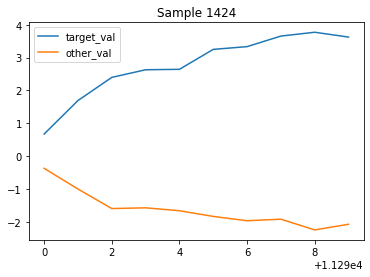

In [19]:
# Plotting the Logit difference between the intended label and the next highest label.
# The target logit is MUCH larger than the next logit which is ideal
all_aum_records[all_aum_records['sample_id'] == highest_sample_aum][['target_val', 'other_val']].plot(
    title=f'Sample {highest_sample_aum}'
)

In [20]:
high_tweet = tweets.iloc[highest_sample_aum]

print(high_tweet['text'])
print(high_tweet['Sentiment'])

Can I have 12 mins of your time to PLEASE LISTEN to this interview as IT'S SO IMPORTANT can my followers RT. url
Extremely Positive


In [21]:
# the lowest AUM
lowest_sample_aum = int(aum_values.iloc[-1].sample_id)

print(lowest_sample_aum)

all_aum_records[all_aum_records['sample_id'] == lowest_sample_aum]

538


,sample_id,num_measurements,target_logit,target_val,other_logit,other_val,margin,aum
4340,538,1,1,-0.412970,0,0.285251,-0.698221,-0.698221
4341,538,2,1,-0.978593,0,0.689916,-1.668509,-1.183365
4342,538,3,1,-1.310608,2,1.859678,-3.170286,-1.845672
4343,538,4,1,-1.901340,2,2.918876,-4.820215,-2.589308
4344,538,5,1,-2.137454,2,2.958105,-5.095560,-3.090558
4345,538,6,1,-1.909854,2,3.145170,-5.055024,-3.417969
4346,538,7,1,-2.203417,2,3.149300,-5.352717,-3.694362
4347,538,8,1,-2.109393,2,3.141662,-5.251055,-3.888948
4348,538,9,1,-1.937160,2,3.225335,-5.162496,-4.030454
4349,538,10,1,-2.240406,2,3.456172,-5.696578,-4.197066


<AxesSubplot:title={'center':'Sample 538'}>

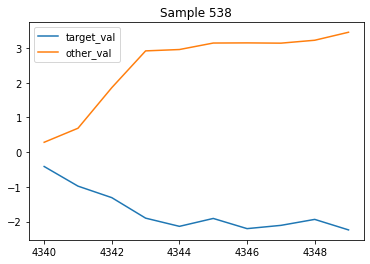

In [22]:
# Plotting the Logit difference between the intended label and the next highest label.
# The next logit is MUCH larger than the target logit which is not ideal
all_aum_records[all_aum_records['sample_id'] == lowest_sample_aum][['target_val', 'other_val']].plot(
    title=f'Sample {lowest_sample_aum}'
)


In [23]:
low_tweet = tweets.iloc[lowest_sample_aum]

print(low_tweet['text'])
print(low_tweet['Sentiment'])

very nice of you not to ask compensation from for causing the SARS virus caused by their overdirty food markets BUT HOW ABOUT this   Demand
Neutral


## Using cosine similarity to find confusing phrases

<img src='https://www.sbert.net/_images/SBERT_Siamese_Network1.png'>

In [24]:
# https://www.sbert.net/docs/usage/semantic_textual_similarity.html

from sentence_transformers import SentenceTransformer, util
# Use a pre-trained model specifically for symmetric semantic text similarity
model = SentenceTransformer('all-MiniLM-L6-v2')

/opt/homebrew/lib/python3.9/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/huggingface_hub/file_download.py:588: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


In [25]:
# Embed all tweets into a vector space
embeddings = model.encode(tweets['text'].tolist(), convert_to_tensor=True)

In [26]:
# Calculate cosine similarity for each pair and set a threshold (higher is more semantically similar)
cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)

COSINE_THRESHOLD = 0.9

In [27]:
# Highlight pairs of tweets that are semantically similar but have different labels
index1, index2 = where(cosine_scores >= COSINE_THRESHOLD)
pairs_to_consider = list(zip(index1.tolist(), index2.tolist()))
for i1, i2 in pairs_to_consider[:len(pairs_to_consider)//2]:
    if i1 != i2:
        samples = tweets[tweets['index'].isin([i1, i2])]
        if samples['Sentiment'].nunique() > 1:
            print(i1, i2, samples[['OriginalTweet', 'Sentiment']].values)
            print('--------')

175 250 [['Covid-19 #heroes: Ã\x82Â\x91The #pub may be closed but that doesnÃ\x82Â\x92t mean we canÃ\x82Â\x92t help peopleÃ\x82Â\x92 https://t.co/RJCkmLDVt5 #coronavirus'
  'Positive']
 ['Covid-19 heroes: Ã\x82Â\x91The pub may be closed but that doesnÃ\x82Â\x92t mean we canÃ\x82Â\x92t help peopleÃ\x82Â\x92\r\r\nhttps://t.co/mpq8VYPrcT #coronavirus positive mindset'
  'Extremely Positive']]
--------
229 440 [["'A Perfect Storm': U.S. Facing Hunger Crisis as Demand for Food Banks Soars https://t.co/wpA6p2XLU7 @theguardian #coronavirus #COVID19 #foodinsecurity"
  'Negative']
 ["'A perfect storm': US facing #hunger #crisis as demand for #foodbanks soars | Environment | The Guardian #ados #pandemic #coronavirus  https://t.co/JboPvSFgLZ"
  'Positive']]
--------
250 175 [['Covid-19 #heroes: Ã\x82Â\x91The #pub may be closed but that doesnÃ\x82Â\x92t mean we canÃ\x82Â\x92t help peopleÃ\x82Â\x92 https://t.co/RJCkmLDVt5 #coronavirus'
  'Positive']
 ['Covid-19 heroes: Ã\x82Â\x91The pub may be clos

# Highlighting a particular pair 

```
1040 [['Need toilet paper Police officers handed out toilet paper rolls at a Sydney supermarket to try to calm panic buying shoppers during the epidemic'
  'Negative']
  
1543 ['Police officers handed out rolls of toilet paper at a Sydney supermarket on Thursday to try to calm shoppers down during the outbreak in Australia'
  'Positive']]
```

In [28]:
# AUM says they are both fairly fine
aum_values[aum_values['sample_id'].isin((1040, 1543))]

,sample_id,aum
1110,1040,2.992025
1252,1543,2.809136


In [29]:
aum_values['aum'].describe()  # AUM values are low but not crazy low

count    1725.000000
mean        3.052935
std         0.904384
min        -4.197066
25%         2.745528
50%         3.254186
75%         3.617598
max         4.447078
Name: aum, dtype: float64

In [30]:
URL_REGEX = re.compile('http(s)?:\/\/t.co\/\w+')
MENTION_REGEX = re.compile('@\w+')
def clean_tweet(tweet):
    # remove mentions, the pound sign, and replace urls with URL token
    tweet = re.sub(URL_REGEX, 'url', tweet)  # replace urls with url. Assumes that the mention of a url is significant
    tweet = re.sub(MENTION_REGEX, '', tweet)  # remove mentions entirely
    tweet = tweet.replace('#', '')  # remove pound signs
    
    return tweet.strip()

In [31]:
# Our model is VERY confident in its predictions
Softmax()(sequence_classification_model(**bert_tokenizer(
    clean_tweet('Need toilet paper Police officers handed out toilet paper rolls at a Sydney supermarket to try to calm panic buying shoppers during the epidemic')
, return_tensors='pt')).logits)

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_66288/2031185257.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  Softmax()(sequence_classification_model(**bert_tokenizer(


tensor([[0.9860, 0.0062, 0.0078]], grad_fn=<SoftmaxBackward0>)

In [32]:
# Our model is VERY confident in its predictions
Softmax()(sequence_classification_model(**bert_tokenizer(
    clean_tweet('Police officers handed out rolls of toilet paper at a Sydney supermarket on Thursday to try to calm shoppers down during the outbreak in Australia')
, return_tensors='pt')).logits)

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_66288/1496898499.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  Softmax()(sequence_classification_model(**bert_tokenizer(


tensor([[0.0061, 0.0047, 0.9892]], grad_fn=<SoftmaxBackward0>)

In [33]:
# Our model may be overfitting making it harder to predict unseen data